# 
Data Science Challenge
#### 31-Mar-2018

# Scenario//Setup
You are a data scientist for an online retailer. The company’s marketing director comes to you to see if you can
help out with a task. The retailer ran at least one marketing campaign in the previous year and they want to see if
you can assess the how successful their efforts were. The rub is that the director does not want to bias your results
so you do not know when the marketing campaign(s) occurred. Your job is to determine the dates that came after
the marketing campaign(s) with the assumption that the campaign was successful and present the results to the
marketing director.

This is a fictional scenario based on the dataset found here: https://archive.ics.uci.edu/ml/datasets/Online+Retail

## Step 1: SQL
Assume the data in the data file you downloaded is stored in a table called purchases. Write a query or queries that
will allow you to find a date or dates where unusually large amounts of items were sold. For this part of the task,
assume you do not have access to R, Python, Excel or visualization aids and just need to use SQL to try to get at an
answer. Explain any assumptions you are making.

__See SYL_detection.sql for query__

## Step 2: Modeling
Describe how you would break down an analysis for the marketing director. What do you believe is the best metric
to measure the effect of a marketing campaign? What are some unknowns and confounds to consider?

Using either R or Python, please write some code to analyze this problem from the original downloaded dataset.
This can be in the form of a Jupyter notebook if you would like but it is not necessary.

### Procedures

Analysis will begin with an in depth conversation with the marketing director to improve understanding of the task and environment the data lives in, as well developing a common understanding of a deliverable. From there, conversations with the data owners would be appropriate to understand the data provenance and any nuances with the data source. Finally, we would move on to the data.

Generally, the following procedures would be followed:

1) Acquire the data from the source

2) Clean/Prepare Data (and follow-up to data owners with questions)

3) Prepare time series analysis (quantity, qty*price, num customers, num invoices, num products)

4) Analyze relative to baseline (prior year data, or an industry standard)

5) Anomoly detection

6) Results

##### Metrics:
1) A large driver of the success/failure of the campaign might be the amount of spend associated with it. Computing the return on investment (ROI) is a good option for evaluating the campaign. However, there could be strategic or long-term objectives with latent indicators that a simple ROI may not accurately capture.
2) The follow items will be evaluated in this analysis:
* sum(quantity sold)
* revenue "sum(qty * price)"
* count(unique customers)[number of different customers per day]
* count(unique invoices) [number unique orders per day]
* count(unique stockCode)[number of unique products sold per day]

In [1]:
# imports
import pandas as pd
import pandas_profiling # conda install -c conda-forge pandas-profiling
import multiprocessing

In [2]:
# get the data
#loc = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
loc = 'T:/Dropbox/Projects/ts_anomolies/Data/OnlineRetail.xlsx'
d = pd.read_excel(loc)
d.shape

(541909, 8)

In [3]:
pandas_profiling.ProfileReport(d)

Number of variables,8
Number of observations,541909
Total Missing (%),3.1%
Total size in memory,33.1 MiB
Average record size in memory,64.0 B
Numeric,3
Categorical,4
Boolean,0
Date,1
Text (Unique),0
Rejected,0


# Data Cleaning, Preparation, Exploration

In [3]:
# create a "YY-MM-DD" type field (ie remove the time of day) so we can groupby a single day
d['Date'] = [str(x.floor('d'))[:10] for x in d.InvoiceDate]

In [4]:
# add a total reve by invoice column
d['rev'] = d.Quantity*d.UnitPrice

In [5]:
# first convert all to strings and replace nan with UNK (unknown flag)
d['CustomerID'] = d['CustomerID'].astype(str).replace('nan', 'UNK')

In [6]:
# drop duplicate rows
# d[np.logical_and(d.InvoiceNo==536409,d.StockCode==21866)]
d.drop_duplicates(inplace=True)

In [7]:
d.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,rev
0,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-09,168469.6
1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6
2,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom,2011-11-25,0.0
3,542504,37413,NaN,5568,2011-01-28 12:03:00,0.00,UNK,United Kingdom,2011-01-28,0.0
4,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,2011-10-27,1008.0


### and is now cleaned, recheck some diagnostics . . . 

In [8]:
pandas_profiling.ProfileReport(d)

Number of variables,11
Number of observations,536641
Total Missing (%),0.0%
Total size in memory,45.0 MiB
Average record size in memory,88.0 B
Numeric,4
Categorical,5
Boolean,0
Date,2
Text (Unique),0
Rejected,0


In [8]:
d_cleaned = 'online_retail_clean.csv'
d.to_csv('T:/Dropbox/Projects/ts_anomolies/Data/{}'.format(d_cleaned), index=False)

# Note: restart kernel after running pandas_profiling, and continue notebook without pandas_profiling (this is a hacky fix)
# there is a compatibility issue w/ matplotlib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

In [2]:
d_cleaned = 'online_retail_clean.csv'
d = pd.read_csv('T:/Dropbox/Projects/ts_anomolies/Data/{}'.format(d_cleaned),
               dtype={'InvoiceNo':str, 'StockCode':str, 'Description':str, 'Quantity':int,
                      'InvoiceDate': object, 'UnitPrice':float, 'CustomerID':str,
                      'Country':str, 'Date': str, 'rev': float})
d.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,rev
0,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-09,168469.6


# Data Analysis
Let's take a look at both days with large quantities sold, and also days with a large number of customers

In [3]:
fun = {'StockCode': 'nunique', # count unique products
       'rev': 'sum',           # sum of revenue
       'CustomerID': 'nunique',# count unique customers
       'InvoiceNo': 'nunique'} # count unique invoices
d_grouped = d.groupby('Date').agg(fun) # apply these functions to each date group

In [4]:
# Import to US e-Commerce trend from 2011
# https://www2.census.gov/retail/releases/historical/ecomm/11q4.pdf
CY2011 = [43713,44224,44550,61789]
d_grouped['USindex'] = None
for x in range(4):
    date=d_grouped.index[round(len(d_grouped.index)*x/4)]
    d_grouped['USindex'][d_grouped.index==date]=CY2011[x]

C:\Users\hende\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


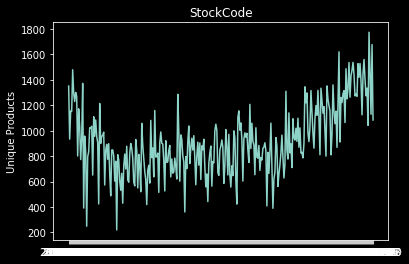

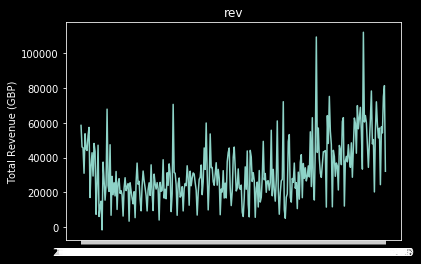

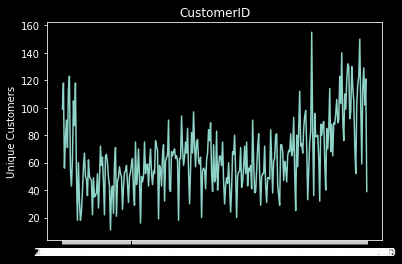

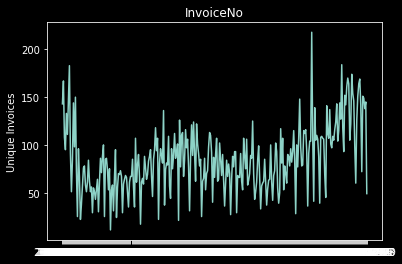

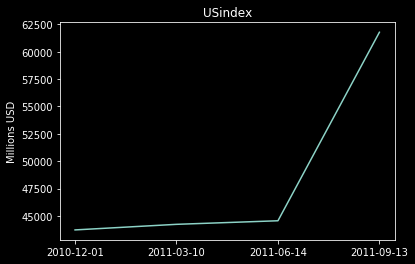

In [5]:
xlabs = ['Unique Products', 'Total Revenue (GBP)', 'Unique Customers', 'Unique Invoices', 'Millions USD']
for i,x in enumerate(d_grouped.columns):
    scaler = StandardScaler()
    plt.style.use('dark_background')
    #y = scaler.fit_transform(d_grouped[x].values.reshape(-1,1))
    y = d_grouped[x].dropna()
    plt.title(x)
    plt.ylabel(xlabs[i])
    plt.plot(y)
    plt.savefig('{}.png'.format(x))
    plt.show()

## Analysis:
As shown above, online retail sales as reported by the US Census Bureau experience an upward seasonal trend as time approaches the holiday season. Likewise, all the metrics in consideration also experience the same trend. Thus, we will attribute the upward trend from approximately September onward to seasonality, rather than a marketing campaign.

C:\Users\hende\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


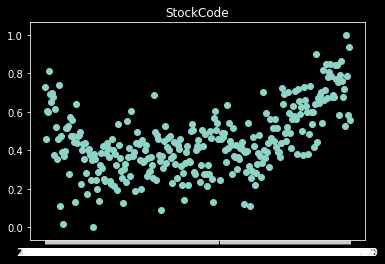

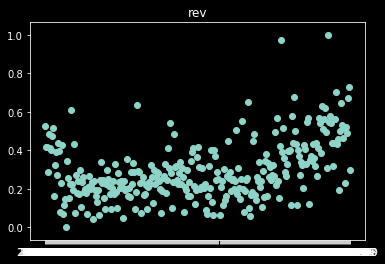

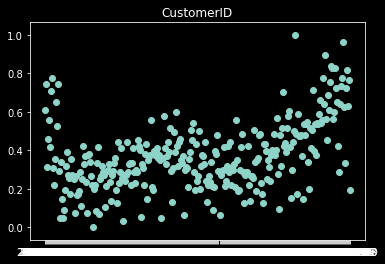

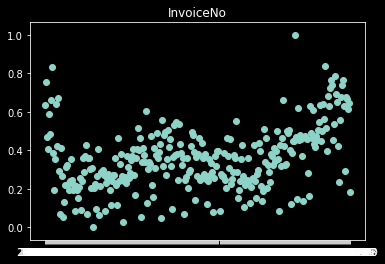

C:\Users\hende\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


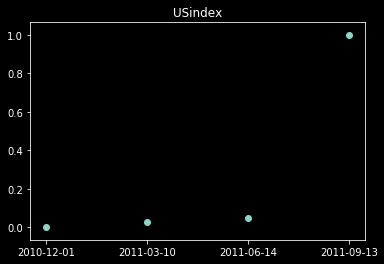

In [6]:
for x in d_grouped.columns:
    scaler = MinMaxScaler()
    plt.style.use('dark_background')
    y = scaler.fit_transform(d_grouped[x].dropna().values.reshape(-1,1))
    plt.title(x)
    plt.scatter(d_grouped[x].dropna().index.values, y, alpha=1)
    plt.show()

### Anomoly Detection

Let's see if anything sticks out across all dimensions.

1) Take a look at PCA

2) Port over to R and use twitter's time series anomaly detection package to see if there are statistically significant anomalies.

3) Bring analysis back into Jupyter Notebook

In [7]:
# first scale all the data, then do PCA
#scaled = StandardScaler().fit_transform(d_grouped[['StockCode','rev', 'CustomerID','InvoiceNo']])
scaled = MinMaxScaler().fit_transform(d_grouped[['StockCode','rev', 'CustomerID','InvoiceNo']])
#scaled = MaxAbsScaler().fit_transform(d_grouped[['StockCode','rev', 'CustomerID','InvoiceNo']])

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(scaled)
pca_df = pd.DataFrame(principalComponents)

In [9]:
pca.explained_variance_ratio_

array([0.82457698])

In [10]:
# put the date back on the df
d_grouped['MM'] = [str(x)[5:7] for x in d_grouped.index]
d_grouped['Date'] = [str(x)[:10] for x in d_grouped.index]
d_grouped['PC1'] = principalComponents

In [11]:
d_grouped.head(1)

,StockCode,rev,CustomerID,InvoiceNo,USindex,MM,Date,PC1
Date,,,,,,,,
2010-12-01,1351,58451.56,99,143,43713,12,2010-12-01,0.516322


In [12]:
print(d_grouped.shape)
print(pca_df.shape)

(305, 8)
(305, 1)


In [13]:
dt=list(d_grouped['MM'])
months=[]
for i, x in enumerate(dt):
    if (i+1)<len(dt):
        if dt[i+1]==x:
            months.append('')
        else:
            months.append(x)
    else:
        months.append('')

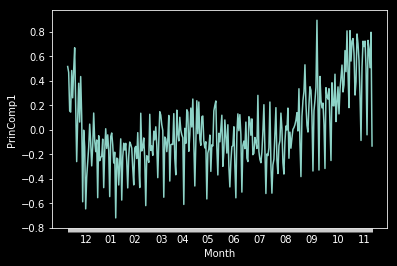

In [14]:
# create a plot of PCA_1 over time
plt.plot(d_grouped['Date'], pca_df[0])
plt.xticks(d_grouped['Date'], months)
plt.style.use('dark_background')
plt.ylabel('PrinComp1')
plt.xlabel('Month')
plt.savefig('pc1_ts.png')
plt.show()

In [15]:
d_grouped.to_csv('Data/pca_df.csv', index=False)

# Read in results from analysis anomaly.R
- saw biggest spikes in revenue on Sep 20 and Nov 14 per analysis in R script, significant at alpha=.05

In [16]:
anom = pd.read_csv('Data/rev_anomalies.csv')
anom.head()

,timestamp,anoms
0,2011-09-20,109228.08
1,2011-10-05,75111.57
2,2011-11-14,111958.62
3,2011-11-23,78223.52
4,2011-12-07,74952.61


In [17]:
anom_dates = list(anom.timestamp[[0,2]])
anom_dates

['2011-09-20', '2011-11-14']

# What happened on these dates?


In [18]:
d_grouped[[x in anom_dates for x in d_grouped.Date.values]]

,StockCode,rev,CustomerID,InvoiceNo,USindex,MM,Date,PC1
Date,,,,,,,,
2011-09-20,900,109228.08,57,77,None,09,2011-09-20,0.239073
2011-11-14,1432,111958.62,110,152,None,11,2011-11-14,0.808944


We know there was high revenue (that's how we spotted these dates).

But who bought our products and how was their behavior different on this day?

In [19]:
# for every customer, calculate average daily spend, and total spend on those two days
results_cust = pd.DataFrame()
for date in anom_dates:
    df = d[d.Date==date].groupby('CustomerID')[['rev']].agg(sum).reset_index()
    df.columns = ['CustomerID', date]
    results_cust = pd.concat([results_cust, df])

In [20]:
# reconcile revenue
print(sum(results_cust['2011-11-14'].dropna()))
print(sum(results_cust['2011-09-20'].dropna()))

111958.61999999997
109228.07999999994


In [21]:
for date in anom_dates:
    print(results_cust.sort_values(date, ascending=False).head())
# here we can see that the top spending customers for each date are not the same between the two days
# perhaps these two comapigns targeted different people?

    2011-09-20  2011-11-14 CustomerID
46    71601.44         NaN    17450.0
56     5900.95         NaN        UNK
25     5639.52         NaN    14866.0
13     2250.90         NaN    13767.0
29     2020.52         NaN    15341.0
     2011-09-20  2011-11-14 CustomerID
109         NaN    55316.08        UNK
29          NaN     7386.79    14096.0
23          NaN     4656.22    13694.0
92          NaN     4489.34    17450.0
68          NaN     4337.38    15838.0


In [22]:
# calculate daily mean rev and std from each customer
xbar=d[['CustomerID','Date','rev']].groupby(['CustomerID','Date'])\
    .agg('sum').groupby('CustomerID').agg('mean').reset_index()
xbar.columns = ['CustomerID', 'MeanDaily']
sigma=d[['CustomerID','Date','rev']].groupby(['CustomerID','Date'])\
    .agg('sum').groupby('CustomerID').agg('std').reset_index()
sigma.columns=['CustomerID', 'SD_daily']
results = xbar.merge(sigma, on='CustomerID')

In [23]:
results.head()
# some values will have SD_daily NAN when n=1

,CustomerID,MeanDaily,SD_daily
0,12346.0,0.000000,NaN
1,12347.0,615.714286,341.070789
2,12348.0,449.310000,301.159918
3,12349.0,1757.550000,NaN
4,12350.0,334.400000,NaN


In [24]:
results_cust.head()

,2011-09-20,2011-11-14,CustomerID
0,366.25,NaN,12352.0
1,-10.20,NaN,12474.0
2,-25.50,NaN,12540.0
3,279.80,NaN,12584.0
4,377.66,NaN,12620.0


### Join the anomoly daily spend with the average daily spend by customer

In [25]:
cust_final = results_cust.merge(results, on='CustomerID')
cust_final.head()

,2011-09-20,2011-11-14,CustomerID,MeanDaily,SD_daily
0,366.25,NaN,12352.0,220.772857,119.615786
1,-10.20,NaN,12474.0,271.721923,295.295730
2,-25.50,NaN,12540.0,700.475789,456.209297
3,279.80,NaN,12584.0,126.263333,203.908906
4,NaN,-73.2,12584.0,126.263333,203.908906


#### calculate the multiplier (more easily interpretable) that each of the customers spent over their (and the z score)

In [26]:
for date in anom_dates:
    cust_final['sep_z'] = (cust_final['2011-09-20']-cust_final.MeanDaily)/cust_final.SD_daily
    cust_final['sep_fac'] = (cust_final['2011-09-20']/cust_final.MeanDaily)
    cust_final['nov_z'] = (cust_final['2011-11-14']-cust_final.MeanDaily)/cust_final.SD_daily
    cust_final['nov_fac'] = (cust_final['2011-11-14']/cust_final.MeanDaily)
cust_final.head()

,2011-09-20,2011-11-14,CustomerID,MeanDaily,SD_daily,sep_z,sep_fac,nov_z,nov_fac
0,366.25,NaN,12352.0,220.772857,119.615786,1.216204,1.658945,NaN,NaN
1,-10.20,NaN,12474.0,271.721923,295.295730,-0.954710,-0.037538,NaN,NaN
2,-25.50,NaN,12540.0,700.475789,456.209297,-1.591322,-0.036404,NaN,NaN
3,279.80,NaN,12584.0,126.263333,203.908906,0.752967,2.216004,NaN,NaN
4,NaN,-73.2,12584.0,126.263333,203.908906,NaN,NaN,-0.978198,-0.579741


# Export some data for presentation

In [27]:
# top 10 customers for sep anom by revenue
cust_final.sort_values('2011-09-20',ascending=False)[['CustomerID', '2011-09-20', 'sep_z', 'sep_fac', 'MeanDaily']].head(10).round(0)

,CustomerID,2011-09-20,sep_z,sep_fac,MeanDaily
52,17450.0,71601.0,5.0,13.0,5676.0
63,UNK,5901.0,0.0,1.0,5226.0
28,14866.0,5640.0,2.0,5.0,1183.0
15,13767.0,2251.0,4.0,6.0,403.0
34,15341.0,2021.0,NaN,1.0,2021.0
29,14911.0,1798.0,1.0,2.0,907.0
17,14164.0,1274.0,1.0,2.0,816.0
38,16029.0,1256.0,0.0,1.0,1182.0
14,13448.0,1061.0,1.0,2.0,433.0
23,14298.0,948.0,-1.0,0.0,1956.0


In [28]:
# average factor on sep anom
cust_final.sep_fac.mean()

1.469434575815007

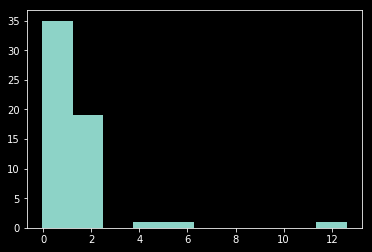

In [29]:
import imp
imp.reload(plt)
plt.hist(cust_final['sep_fac'].dropna())
plt.savefig('sep_fac.png')

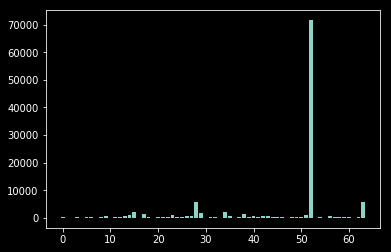

In [30]:
#plt.pie(cust_final['2011-09-20'].dropna())
plt.bar(x=cust_final.index,height=cust_final['2011-09-20'])
plt.savefig('sep_customers.png')
plt.show()


In [31]:
# checksum
round(cust_final['2011-09-20'].sum()) == round(d[d.Date=='2011-09-20'].rev.sum())

True

In [32]:
# novemver anom
cust_final.sort_values('2011-11-14',ascending=False)[['CustomerID', '2011-11-14', 'nov_z', 'nov_fac', 'MeanDaily']].head(10).round(0)

,CustomerID,2011-11-14,nov_z,nov_fac,MeanDaily
64,UNK,55316.0,7.0,11.0,5226.0
91,14096.0,7387.0,2.0,2.0,3360.0
86,13694.0,4656.0,2.0,3.0,1529.0
53,17450.0,4489.0,-0.0,1.0,5676.0
128,15838.0,4337.0,1.0,2.0,1962.0
120,15482.0,2973.0,2.0,5.0,639.0
10,13089.0,1365.0,1.0,2.0,691.0
134,16303.0,1324.0,-0.0,1.0,1326.0
150,17404.0,1238.0,-0.0,1.0,2020.0
98,14680.0,1168.0,-1.0,1.0,1683.0


In [33]:
# checksum
round(cust_final['2011-11-14'].sum()) == round(d[d.Date=='2011-11-14'].rev.sum())

True

In [34]:
cust_final.nov_fac.mean()

1.0423922548428306

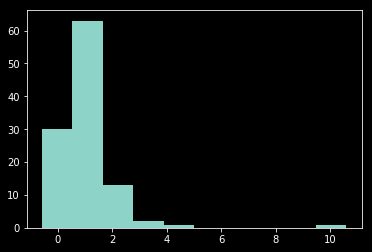

In [35]:
import matplotlib.pyplot as plt
plt.hist(cust_final.nov_fac.dropna())
plt.show()
plt.savefig('nov_fac.png')

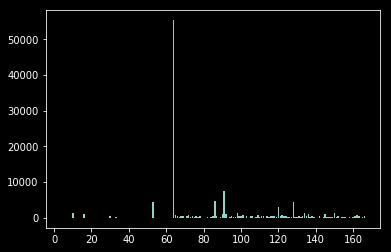

In [36]:
plt.bar(x=cust_final.index,height=cust_final['2011-11-14'])
plt.savefig('nov_customers.png')
plt.show()

In [37]:
# checksum
round(cust_final['2011-11-14'].sum()) == round(d[d.Date=='2011-11-14'].rev.sum())

True

# Customer 17450

In [38]:
# just on sep 20
d[np.logical_and(d.CustomerID=='17450.0', d.Date=='2011-09-20')].sort_values('rev', ascending=False).head(10).groupby('Description').agg(sum).sort_values('rev', ascending=False)

,Quantity,UnitPrice,rev
Description,,,
SET OF TEA COFFEE SUGAR TINS PANTRY,1412,5.06,7144.72
PANTRY CHOPPING BOARD,756,5.06,3825.36
SET OF 6 SPICE TINS PANTRY DESIGN,852,4.25,3621.00
SET OF 3 CAKE TINS PANTRY DESIGN,612,5.18,3170.16
DOORSTOP RETROSPOT HEART,744,4.08,3035.52
PANTRY ROLLING PIN,708,4.18,2959.44
SET OF 10 LED DOLLY LIGHTS,416,6.50,2704.00
RETROSPOT HEART HOT WATER BOTTLE,496,5.10,2529.60
SCOTTIE DOG HOT WATER BOTTLE,496,5.10,2529.60


In [39]:
# all year
d[d.CustomerID=='17450.0'].sort_values('rev', ascending=False).head(10).groupby('Description').agg(sum).sort_values('rev', ascending=False)

,Quantity,UnitPrice,rev
Description,,,
SET OF TEA COFFEE SUGAR TINS PANTRY,1412,5.06,7144.72
WHITE HANGING HEART T-LIGHT HOLDER,2002,6.44,6446.80
HEART OF WICKER LARGE,1284,3.21,4121.64
PANTRY CHOPPING BOARD,756,5.06,3825.36
SET OF 6 SPICE TINS PANTRY DESIGN,852,4.25,3621.00
SET OF 3 CAKE TINS PANTRY DESIGN,612,5.18,3170.16
DOG BOWL CHASING BALL DESIGN,756,4.18,3160.08
DOORSTOP RETROSPOT HEART,744,4.08,3035.52
PANTRY ROLLING PIN,708,4.18,2959.44


In [40]:
cust17450=d[d.CustomerID=='17450.0'].groupby('Date').agg(sum)

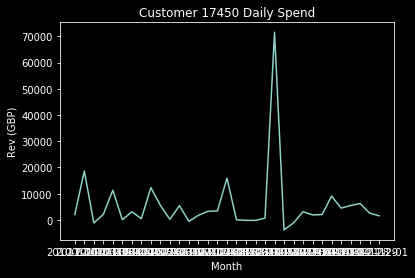

In [41]:
plt.plot(cust17450.rev)
plt.ylabel('Rev (GBP)')
plt.xlabel('Month')
plt.title('Customer 17450 Daily Spend')
plt.savefig('cust1745_sep.png')
plt.show()

In [42]:
cust17450.rev

Date
2010-12-07     2028.84
2011-01-11    18620.20
2011-02-11    -1132.08
2011-03-09     2099.70
2011-03-24    11343.20
2011-03-25       57.60
2011-04-20     3082.90
2011-04-27      476.40
2011-05-24    12293.88
2011-05-26     5518.68
2011-05-31      213.12
2011-06-16     5405.48
2011-06-21     -545.58
2011-07-12     1752.06
2011-07-14     3279.36
2011-07-28     3453.72
2011-08-17    15924.90
2011-08-23       34.56
2011-08-31     -167.08
2011-09-02     -200.00
2011-09-05      691.20
2011-09-20    71601.44
2011-09-21    -3825.36
2011-09-29    -1140.78
2011-09-30     3120.00
2011-10-24     1896.72
2011-10-31     2039.24
2011-11-03     9069.82
2011-11-14     4489.34
2011-11-21     5490.24
2011-11-28     6233.36
2011-11-29     2554.69
2011-12-01     1562.40
Name: rev, dtype: float64

# Loook at Revenue without customer 17450.0 and 'UNK' pool
# (Future Research)

In [43]:
outliers = np.logical_or(d.CustomerID=='17450.0', d.CustomerID=='UNK')

removedOutliers = d[np.logical_not(outliers)].groupby('Date').agg(sum)

In [44]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams.update({'font.size': 22})

C:\Users\hende\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


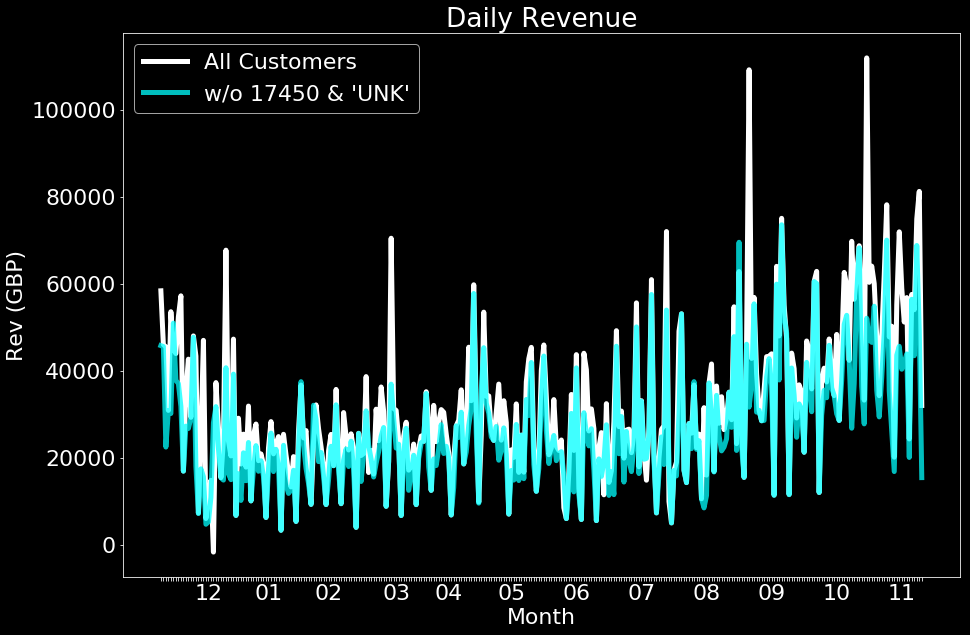

In [45]:
plt.gca().set_color_cycle(['white', 'cyan'])
plt.plot(d.groupby('Date').rev.agg(sum), linewidth=5.0, label='All Customers')
plt.plot(removedOutliers.rev, linewidth=5, label="w/o 17450 & 'UNK'", alpha=.75)
plt.legend()
plt.ylabel('Rev (GBP)')
plt.xlabel('Month')
plt.title('Daily Revenue')
plt.xticks(d_grouped['Date'], months)
plt.savefig('rev_daily_outlier_compare.png')
plt.show()

C:\Users\hende\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


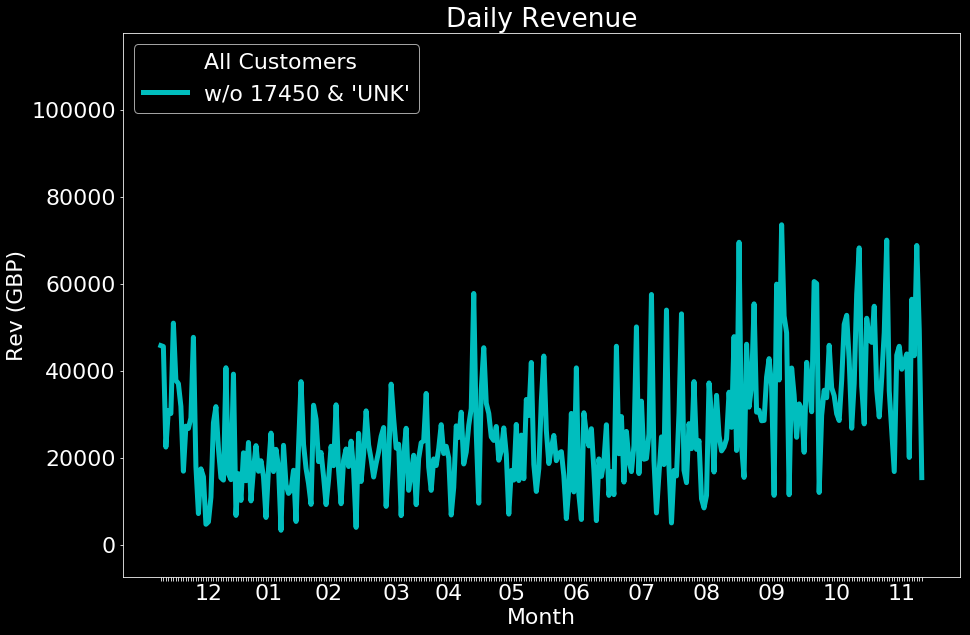

In [46]:
plt.gca().set_color_cycle(['white', 'cyan'])
plt.plot(d.groupby('Date').rev.agg(sum), linewidth=5.0, label='All Customers',alpha=0)
plt.plot(removedOutliers.rev, linewidth=5, label="w/o 17450 & 'UNK'", alpha=.75)
plt.legend()
plt.ylabel('Rev (GBP)')
plt.xlabel('Month')
plt.title('Daily Revenue')
plt.xticks(d_grouped['Date'], months)
plt.savefig('rev_daily_no_outlier.png')
plt.show()

## Manual Analysis of PCA: optional

In [47]:
pca_df[pca_df[0] == max(pca_df[0])]

,0
249,0.893709


# Let's take a look at what happened on October 6th

In [48]:
oct6='2011-10-06'
d_grouped[d_grouped.index==oct6]

,StockCode,rev,CustomerID,InvoiceNo,USindex,MM,Date,PC1
Date,,,,,,,,
2011-10-06,1317,55177.01,155,218,None,10,2011-10-06,0.893709


# Looks like we sold 1317 different products to 155 customers on 218 invoices for about 55k GBP

In [49]:
d[d.Date==oct6].groupby('CustomerID')[['rev']].sum().sort_values('rev', ascending=False).head(10)

,rev
CustomerID,
15838.0,10992.96
13422.0,2626.30
12939.0,2545.68
UNK,2503.39
15769.0,2327.00
12757.0,1708.32
12626.0,1377.55
12627.0,1183.72
17139.0,1173.29


In [50]:
# get the top 10 customers by revenue
customers = d[d.Date==oct6].groupby(['CustomerID','Date'])[['rev']].sum().sort_values('rev', ascending=False).reset_index().CustomerID[:10]

In [51]:
# here they are
customers

0    15838.0
1    13422.0
2    12939.0
3        UNK
4    15769.0
5    12757.0
6    12626.0
7    12627.0
8    17139.0
9    13771.0
Name: CustomerID, dtype: object

In [52]:
cust_summary = []
for x in customers:
    df = d[d.CustomerID==x]
    avgRev = df.groupby('Date')['rev'].sum().agg('mean')
    cust_summary.append([x,round(avgRev)])

In [53]:
# what is each customers average spend?
pd.DataFrame(cust_summary)

,0,1
0,15838.0,1962
1,13422.0,1301
2,12939.0,1930
3,UNK,5226
4,15769.0,2159
5,12757.0,421
6,12626.0,491
7,12627.0,640
8,17139.0,881
9,13771.0,658


In [54]:
d[d.Date==oct6].groupby('StockCode')[['rev']].sum().sort_values('rev', ascending=False).head(10)

,rev
StockCode,
85099B,2558.77
22386,1698.36
22379,1351.70
85099F,1277.93
22759,985.94
22381,967.00
22423,867.66
23199,820.00
20713,628.46


In [55]:
# How about we compare what people spent on Oct 6 vs. what they spent per day the rest of the year on avg?

# calculate each customers avg daily spend
results=d.groupby(['CustomerID','Date'])['rev'].sum().groupby(['CustomerID'])\
.agg('mean').reset_index()

In [56]:
results.columns = ['CustomerID', 'AvgDailySpend']

In [57]:
results.head()

,CustomerID,AvgDailySpend
0,12346.0,0.000000
1,12347.0,615.714286
2,12348.0,449.310000
3,12349.0,1757.550000
4,12350.0,334.400000


In [58]:
# calculate what each customer spent on oct6
results2 = d[d.Date==oct6][['CustomerID','rev']].groupby('CustomerID').agg(sum).reset_index()
final_results=results.merge(results2, on='CustomerID')
final_results.rename(columns={'rev':'Oct6Spend'}, inplace=True)
final_results.head()

,CustomerID,AvgDailySpend,Oct6Spend
0,12431.0,396.805625,678.76
1,12500.0,382.388182,120.35
2,12523.0,134.274615,157.00
3,12569.0,150.555185,397.80
4,12584.0,126.263333,-48.35


In [59]:
final_results['factor'] = final_results.Oct6Spend/final_results.AvgDailySpend

In [60]:
final_results.sort_values('factor', ascending=False).head(10)

,CustomerID,AvgDailySpend,Oct6Spend,factor
102,15838.0,1961.809412,10992.96,5.603480
11,12757.0,420.525000,1708.32,4.062351
146,17813.0,328.358000,966.43,2.943221
144,17651.0,323.889167,915.49,2.826553
5,12626.0,491.411538,1377.55,2.803251
43,13816.0,138.760000,371.69,2.678654
3,12569.0,150.555185,397.80,2.642221
111,16316.0,275.556000,726.10,2.635036
20,13078.0,310.807000,759.88,2.444861
73,14738.0,143.326667,326.81,2.280176


In [61]:
# cleanup -inf values
final_results['factor'].replace([np.inf, -np.inf], np.nan, inplace=True)
final_results.dropna(inplace=True)

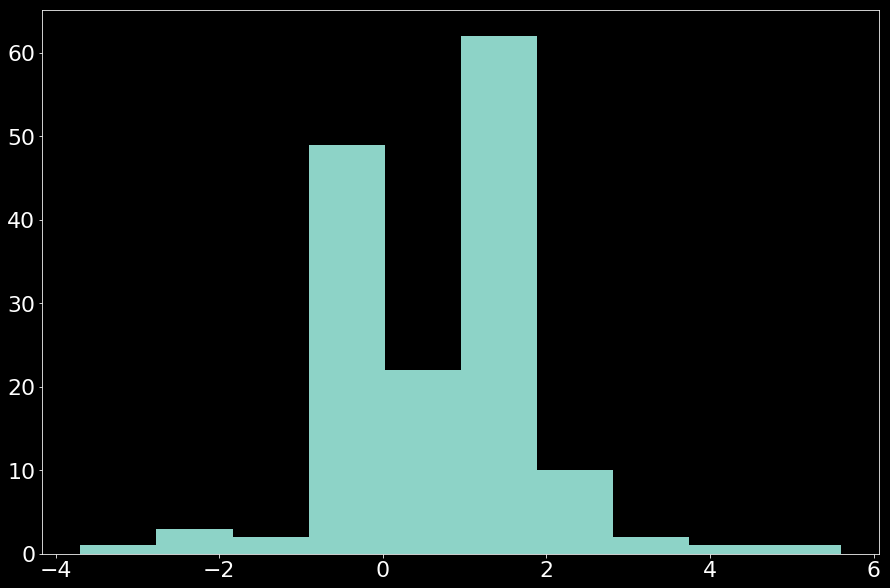

In [62]:
plt.hist(final_results.factor)
plt.savefig('factor_hist.png')
plt.show()

# Customers who bought products on October 6th actually spent about 27% less than they normally do...but several spent way more than usual

In [63]:
final_results.factor.mean()

0.7339772672953229

In [64]:
final_results

,CustomerID,AvgDailySpend,Oct6Spend,factor
0,12431.0,396.805625,678.76,1.710560
1,12500.0,382.388182,120.35,0.314733
2,12523.0,134.274615,157.00,1.169246
3,12569.0,150.555185,397.80,2.642221
4,12584.0,126.263333,-48.35,-0.382930
5,12626.0,491.411538,1377.55,2.803251
6,12627.0,639.790000,1183.72,1.850170
7,12628.0,192.402500,333.64,1.734073
8,12679.0,132.333750,-11.80,-0.089168
9,12703.0,137.350000,-8.85,-0.064434


# Further research - conduct this comparison for all customers on all days of the year to determine which days impacts each individual the most